In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import glob 
import keras
import pathlib
import tensorflow as tf
import tensorflow_addons as tfa
import skimage.color as scc

from skimage import io
from random import randint
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator as ID
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional

In [139]:
conda install keras

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.



EnvironmentLocationNotFound: Not a conda environment: C:\Users\Sriya



In [134]:
pip install np_utils

     ---------------------------------------- 62.0/62.0 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56454 sha256=93e3ed86a17c61397616d22db8edebcb7a0d1e901588f9333a9a250742ef5c5e
  Stored in directory: c:\users\sriya nukala\appdata\local\pip\cache\wheels\c9\5e\52\216e2fa9b02d46b865d8160e7fe29dcf98f89a2fb7be254877
Successfully built np_utils
Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install tensorflow

     -------------------------------------- 284.1/284.1 MB 2.9 MB/s eta 0:00:00
     -------------------------------------- 440.7/440.7 kB 6.8 MB/s eta 0:00:00
     ---------------------------------------- 65.5/65.5 kB 3.5 MB/s eta 0:00:00
     ---------------------------------------- 24.4/24.4 MB 3.7 MB/s eta 0:00:00
     ---------------------------------------- 5.5/5.5 MB 4.0 MB/s eta 0:00:00
     -------------------------------------- 130.2/130.2 kB 3.9 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 4.7 MB/s eta 0:00:00
     -------------------------------------- 938.6/938.6 kB 5.4 MB/s eta 0:00:00
     ---------------------------------------- 3.7/3.7 MB 4.2 MB/s eta 0:00:00
     ---------------------------------------- 57.5/57.5 kB 3.1 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 4.9 MB/s eta 0:00:00
     ------------------------------------- 182.0/182.0 kB 10.7 MB/s eta 0:00:00
     -------------------------------------- 151.

In [2]:
pip install tensorflow_addons

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [4]:
dataset_path = r'C:\Users\Sriya Nukala\Downloads\Dataset1\gaussian_filtered_images'
filepaths=[]
labels=[]

In [5]:
folds = os.listdir(dataset_path)

In [6]:
folds

['export.pkl', 'Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

In [7]:
for fold in folds:
    foldpath = os.path.join(dataset_path, fold)  
    # skip export.pkl file
    if pathlib.Path(foldpath).suffix == '':
        filelist = os.listdir(foldpath)

        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

In [8]:
img_paths = pd.Series(filepaths, name= 'filepaths')
img_labels = pd.Series(labels, name='labels')
dataset = pd.concat([img_paths, img_labels], axis= 1)

In [9]:
dataset

filepaths  labels
0     C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...    Mild
1     C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...    Mild
2     C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...    Mild
3     C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...    Mild
4     C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...    Mild
...                                                 ...     ...
3657  C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...  Severe
3658  C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...  Severe
3659  C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...  Severe
3660  C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...  Severe
3661  C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...  Severe

[3662 rows x 2 columns]

In [10]:
batch_size=3662
img=224
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

gen=ID()
data_gen = gen.flow_from_dataframe( dataset,x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)


Found 3662 validated image filenames belonging to 5 classes.


In [11]:
img_data, img_labels = data_gen.next()

In [12]:
print(img_data.shape, img_labels.shape)

(3662, 224, 224, 3) (3662, 5)


In [13]:
img_labels

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.]], dtype=float32)

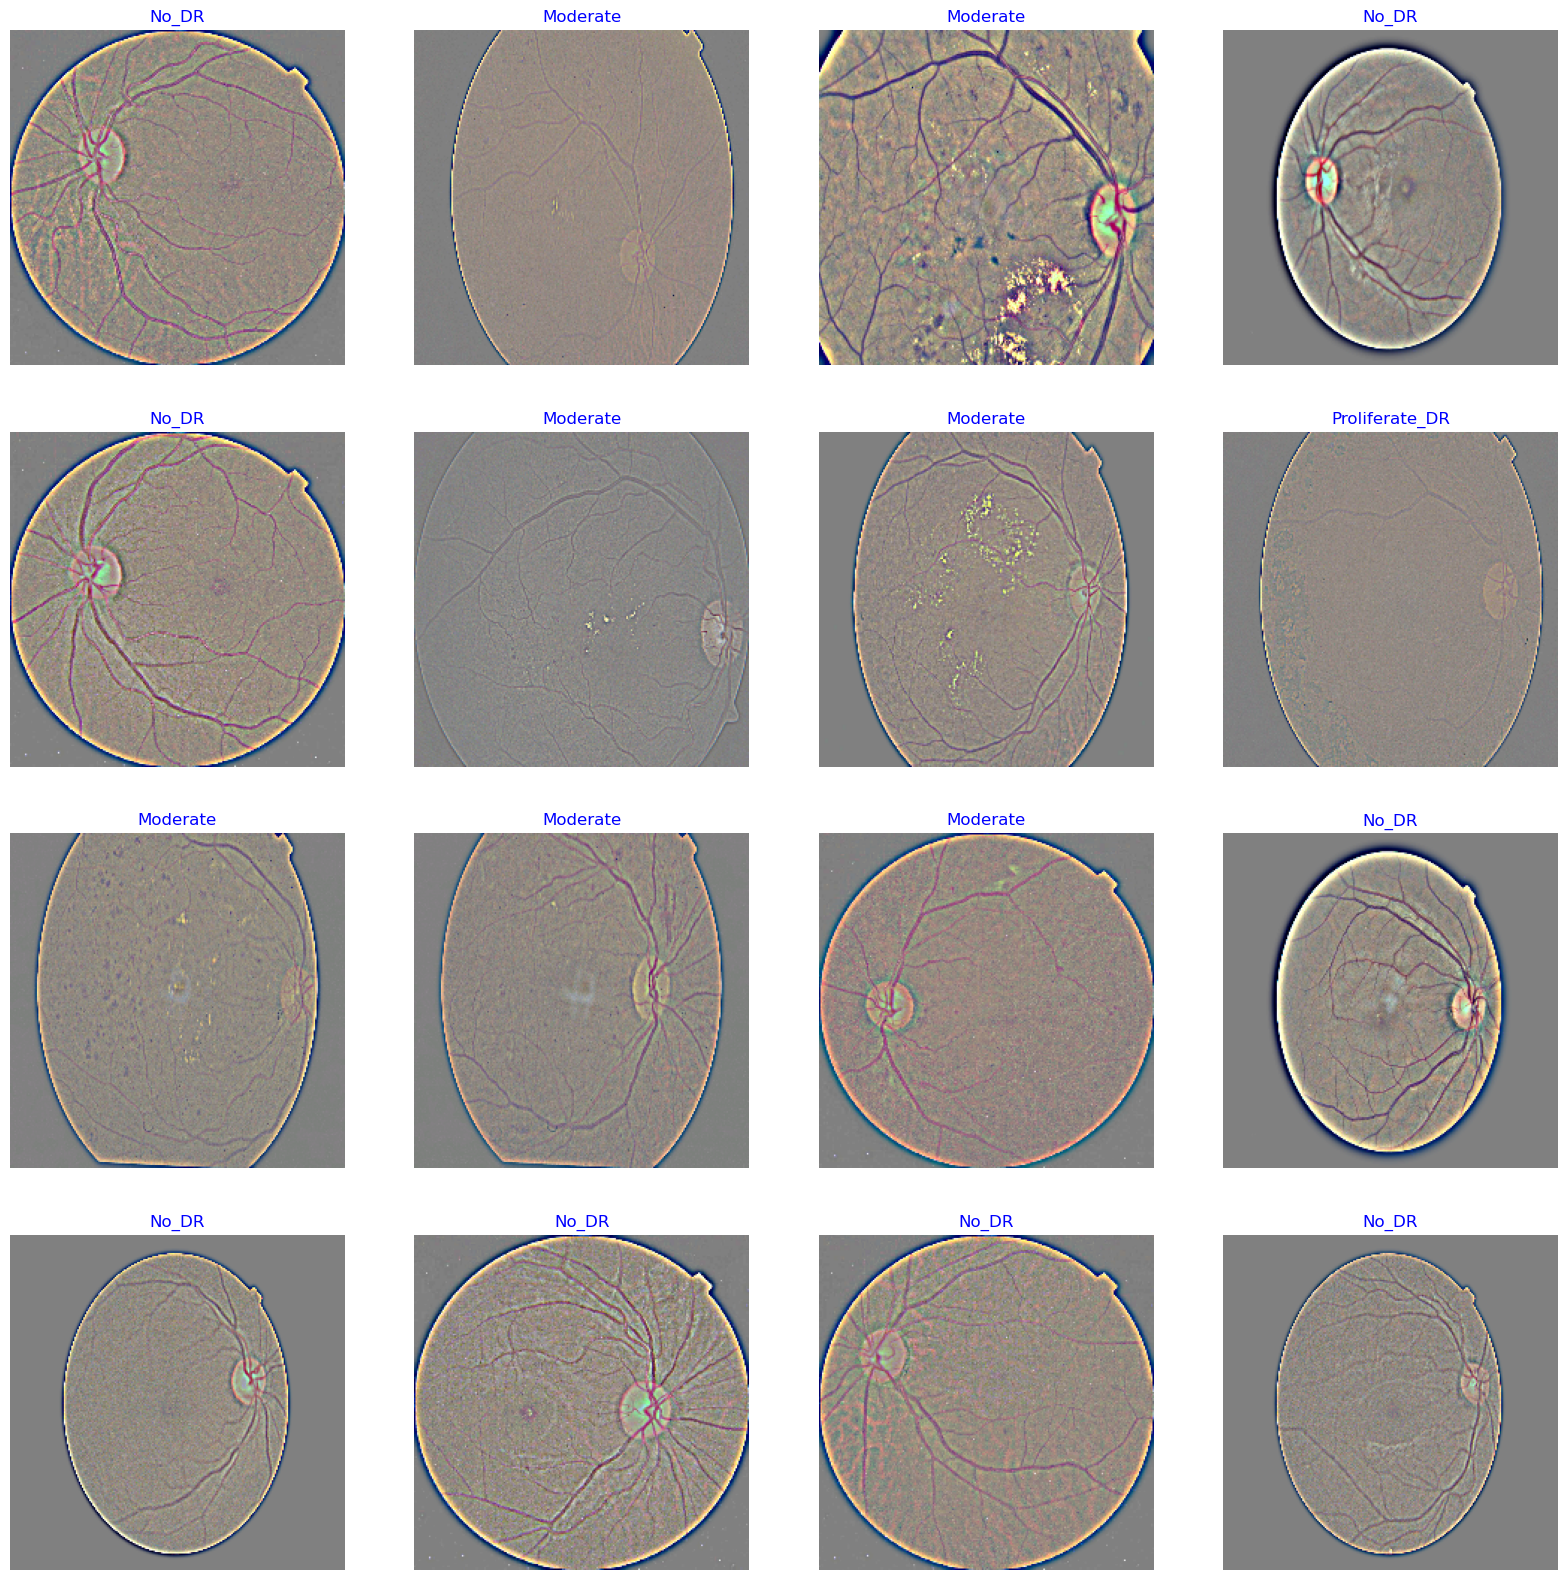

In [14]:
g_dict = data_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(data_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [15]:
train_data, test_data, train_labels, test_labels = train_test_split(img_data, img_labels, test_size = 0.25, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [16]:
sm = SMOTE(random_state=42)

train_data1, train_labels1 = sm.fit_resample(train_data.reshape(-1, img * img * 3), train_labels)

train_data2 = train_data1.reshape(-1, img, img, 3)

print(train_data2.shape, train_labels1.shape)

(5435, 224, 224, 3) (5435, 5)


In [17]:
test_data1, test_labels1 = sm.fit_resample(test_data.reshape(-1, img * img * 3), test_labels)

test_data2 = test_data1.reshape(-1, img, img, 3)

print(test_data2.shape, test_labels1.shape)

(2285, 224, 224, 3) (2285, 5)


In [18]:
val_data1, val_labels1 = sm.fit_resample(val_data.reshape(-1, img * img * 3), val_labels)

val_data2 = val_data1.reshape(-1, img, img, 3)

print(val_data2.shape, val_labels1.shape)

(1305, 224, 224, 3) (1305, 5)


In [19]:
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.models import Model

In [20]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='Accuracy'),
           tf.keras.metrics.AUC(name='AUC'),
           tfa.metrics.F1Score(num_classes=5)]

In [21]:
enetb3 = EfficientNetB3(input_shape = (224,224,3), weights = 'imagenet', include_top = False)
for layer in enetb3.layers:
    layer.trainable = False
# x = BatchNormalization()(enetb3.output)
# x = Conv2D(64, kernel_size=(5,5),activation='relu')(enetb3.output)
x = Flatten()(enetb3.output)
x = Dense(128, activation = 'relu')(x) 
x = Dense(64, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(5, activation = 'softmax')(x) 
model = Model(inputs = enetb3.input, outputs = x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

                                                                                                  
 block2a_expand_conv (Conv2  (None, 112, 112, 144)        3456      ['block1b_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block2a_expand_bn (BatchNo  (None, 112, 112, 144)        576       ['block2a_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block2a_expand_activation   (None, 112, 112, 144)        0         ['block2a_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block2a_d

 block2c_expand_conv (Conv2  (None, 56, 56, 192)          6144      ['block2b_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block2c_expand_bn (BatchNo  (None, 56, 56, 192)          768       ['block2c_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block2c_expand_activation   (None, 56, 56, 192)          0         ['block2c_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block2c_dwconv (DepthwiseC  (None, 56, 56, 192)          1728      ['block2c_expand_activation[0]
 onv2D)   

 D)                                                                                               
                                                                                                  
 block3b_expand_bn (BatchNo  (None, 28, 28, 288)          1152      ['block3b_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block3b_expand_activation   (None, 28, 28, 288)          0         ['block3b_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block3b_dwconv (DepthwiseC  (None, 28, 28, 288)          7200      ['block3b_expand_activation[0]
 onv2D)                                                             [0]']                         
          

 block4a_expand_conv (Conv2  (None, 28, 28, 288)          13824     ['block3c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block4a_expand_bn (BatchNo  (None, 28, 28, 288)          1152      ['block4a_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block4a_expand_activation   (None, 28, 28, 288)          0         ['block4a_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block4a_dwconv_pad (ZeroPa  (None, 29, 29, 288)          0         ['block4a_expand_activation[0]
 dding2D) 

 D)                                                                                               
                                                                                                  
 block4c_expand_bn (BatchNo  (None, 14, 14, 576)          2304      ['block4c_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block4c_expand_activation   (None, 14, 14, 576)          0         ['block4c_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block4c_dwconv (DepthwiseC  (None, 14, 14, 576)          5184      ['block4c_expand_activation[0]
 onv2D)                                                             [0]']                         
          

 block4e_expand_conv (Conv2  (None, 14, 14, 576)          55296     ['block4d_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block4e_expand_bn (BatchNo  (None, 14, 14, 576)          2304      ['block4e_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block4e_expand_activation   (None, 14, 14, 576)          0         ['block4e_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block4e_dwconv (DepthwiseC  (None, 14, 14, 576)          5184      ['block4e_expand_activation[0]
 onv2D)   

 rmalization)                                                                                     
                                                                                                  
 block5b_expand_activation   (None, 14, 14, 816)          0         ['block5b_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block5b_dwconv (DepthwiseC  (None, 14, 14, 816)          20400     ['block5b_expand_activation[0]
 onv2D)                                                             [0]']                         
                                                                                                  
 block5b_bn (BatchNormaliza  (None, 14, 14, 816)          3264      ['block5b_dwconv[0][0]']      
 tion)                                                                                            
          

 block5d_expand_bn (BatchNo  (None, 14, 14, 816)          3264      ['block5d_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block5d_expand_activation   (None, 14, 14, 816)          0         ['block5d_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block5d_dwconv (DepthwiseC  (None, 14, 14, 816)          20400     ['block5d_expand_activation[0]
 onv2D)                                                             [0]']                         
                                                                                                  
 block5d_bn (BatchNormaliza  (None, 14, 14, 816)          3264      ['block5d_dwconv[0][0]']      
 tion)    

                                                                                                  
 block6a_expand_bn (BatchNo  (None, 14, 14, 816)          3264      ['block6a_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6a_expand_activation   (None, 14, 14, 816)          0         ['block6a_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block6a_dwconv_pad (ZeroPa  (None, 17, 17, 816)          0         ['block6a_expand_activation[0]
 dding2D)                                                           [0]']                         
                                                                                                  
 block6a_d

 block6c_expand_bn (BatchNo  (None, 7, 7, 1392)           5568      ['block6c_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6c_expand_activation   (None, 7, 7, 1392)           0         ['block6c_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block6c_dwconv (DepthwiseC  (None, 7, 7, 1392)           34800     ['block6c_expand_activation[0]
 onv2D)                                                             [0]']                         
                                                                                                  
 block6c_bn (BatchNormaliza  (None, 7, 7, 1392)           5568      ['block6c_dwconv[0][0]']      
 tion)    

                                                                                                  
 block6e_expand_bn (BatchNo  (None, 7, 7, 1392)           5568      ['block6e_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6e_expand_activation   (None, 7, 7, 1392)           0         ['block6e_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block6e_dwconv (DepthwiseC  (None, 7, 7, 1392)           34800     ['block6e_expand_activation[0]
 onv2D)                                                             [0]']                         
                                                                                                  
 block6e_b

 D)                                                                                               
                                                                                                  
 block7a_expand_bn (BatchNo  (None, 7, 7, 1392)           5568      ['block7a_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block7a_expand_activation   (None, 7, 7, 1392)           0         ['block7a_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block7a_dwconv (DepthwiseC  (None, 7, 7, 1392)           12528     ['block7a_expand_activation[0]
 onv2D)                                                             [0]']                         
          

 top_activation (Activation  (None, 7, 7, 1536)           0         ['top_bn[0][0]']              
 )                                                                                                
                                                                                                  
 flatten (Flatten)           (None, 75264)                0         ['top_activation[0][0]']      
                                                                                                  
 dense (Dense)               (None, 128)                  9633920   ['flatten[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 64)                   8256      ['dense[0][0]']               
                                                                                                  
 dropout (Dropout)           (None, 64)                   0         ['dense_1[0][0]']             
          

In [23]:
history = model.fit(train_data2,train_labels1, epochs= 35,verbose= 1, validation_data= (val_data2,val_labels1), 
                    validation_steps= None, shuffle= False,batch_size=32)

Epoch 1/35
170/170 [==============================] - 352s 2s/step - loss: 4.0136 - Accuracy: 0.6291 - AUC: 0.8438 - f1_score: 0.6325 - val_loss: 30.5544 - val_Accuracy: 0.2000 - val_AUC: 0.5000 - val_f1_score: 0.0667
Epoch 2/35
170/170 [==============================] - 321s 2s/step - loss: 2.1687 - Accuracy: 0.3785 - AUC: 0.7297 - f1_score: 0.3657 - val_loss: 1.5017 - val_Accuracy: 0.2621 - val_AUC: 0.5918 - val_f1_score: 0.1665
Epoch 3/35
170/170 [==============================] - 308s 2s/step - loss: 1.4183 - Accuracy: 0.2891 - AUC: 0.6565 - f1_score: 0.2480 - val_loss: 1.6197 - val_Accuracy: 0.2008 - val_AUC: 0.5053 - val_f1_score: 0.0684
Epoch 4/35
170/170 [==============================] - 308s 2s/step - loss: 1.4481 - Accuracy: 0.2769 - AUC: 0.6386 - f1_score: 0.2370 - val_loss: 1.4959 - val_Accuracy: 0.2667 - val_AUC: 0.5956 - val_f1_score: 0.1706
Epoch 5/35
170/170 [==============================] - 308s 2s/step - loss: 1.4002 - Accuracy: 0.2894 - AUC: 0.6612 - f1_score: 0.25

KeyboardInterrupt: 

In [20]:
train_scores = model.evaluate(train_data, train_labels)
val_scores = model.evaluate(val_data, val_labels)
test_scores = model.evaluate(test_data,test_labels)

print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

29/29 [==============================] - 41s 1s/step - loss: 1.0736 - Accuracy: 0.7620 - AUC: 0.9270 - f1_score: 0.5362
Training Accuracy: 96.04%
Validation Accuracy: 76.36%
Testing Accuracy: 76.20%


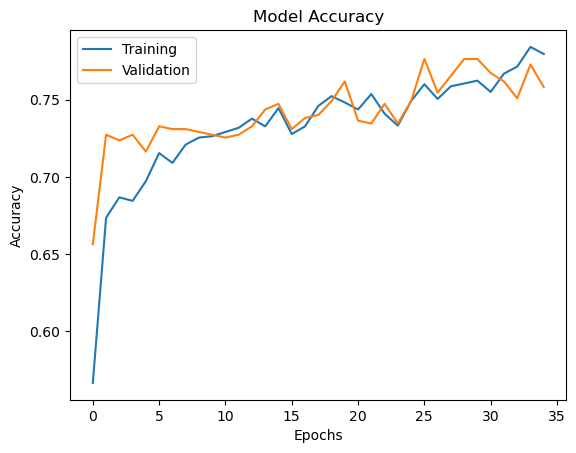

In [21]:
fig, ax = plt.subplots()
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
fig.savefig('Model Accuracy_efficientnetb3_nsm_nes-35.png', format='png', dpi=300)

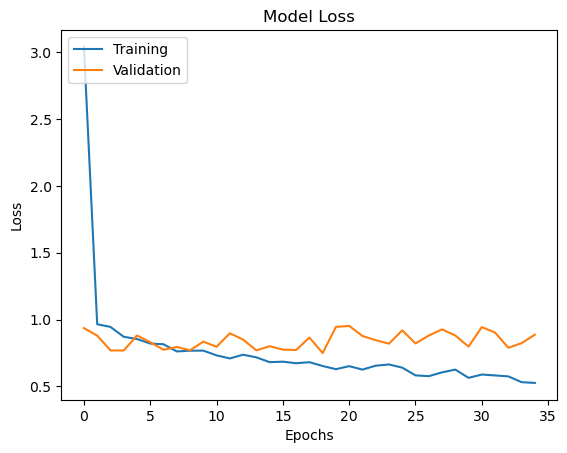

In [22]:
fig, ax = plt.subplots()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
fig.savefig('Model Loss_efficientnetb3_nsm_nes-35.png', format='png', dpi=300)

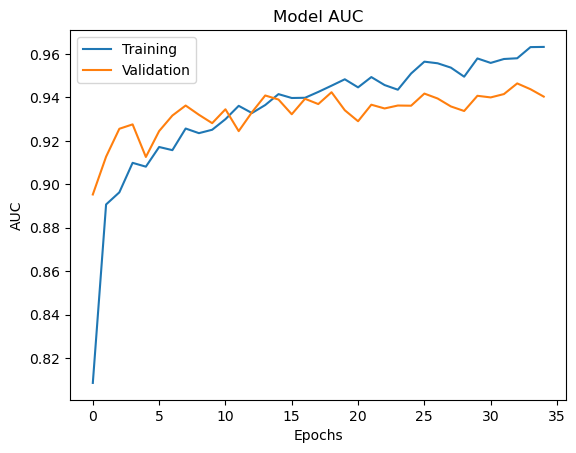

In [23]:
fig, ax = plt.subplots()
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
fig.savefig('Model AUC_efficientnetb3_nsm_nes-35.png', format='png', dpi=300)

In [24]:
pred_labels = model.predict(test_data)

29/29 [==============================] - 50s 2s/step


In [25]:
from sklearn import metrics
auc = metrics.roc_auc_score(test_labels,pred_labels,multi_class='ovo')
auc

0.897416039293082

In [26]:
auc

0.897416039293082

In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)
conf_arr

array([[ 33,  29,  11,   0,   0],
       [ 15, 225,   6,   0,   0],
       [  9,   2, 470,   0,   0],
       [  6,  67,   0,   0,   0],
       [  0,  43,   0,   0,   0]], dtype=int64)

In [30]:
CLASSES=['No_DR','Mild','Moderate','Severe','Proliferate_DR']

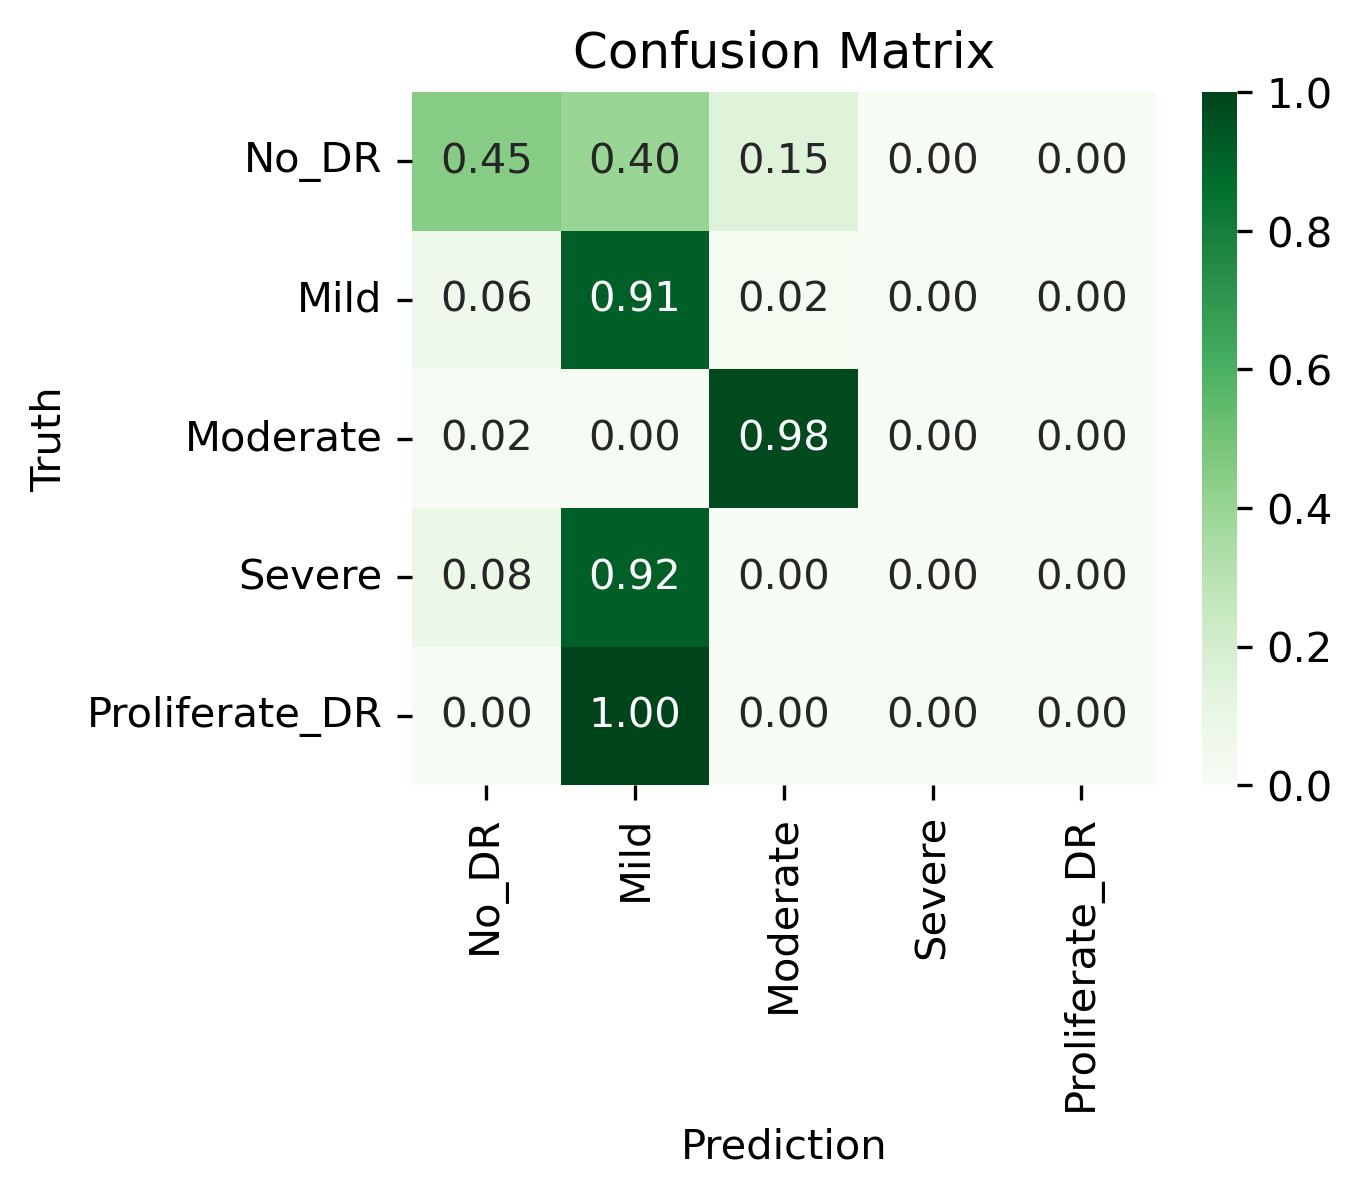

In [31]:
# pred_ls = np.argmax(pred_labels, axis=1)
# test_ls = np.argmax(test_labels, axis=1)

# conf_arr = confusion_matrix(test_ls, pred_ls)
cmn = conf_arr.astype('float') / conf_arr.sum(axis=1)[:, np.newaxis]
fig=plt.figure(figsize=(4,3), dpi=300, facecolor='w', edgecolor='k')

ax = sns.heatmap(cmn, cmap='Greens', annot=True, fmt=".2f", xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)
ax.figure.savefig('confmatrix_ENETB3-35.png', format='png', dpi=300)

In [32]:
pred_labels1=np.argmax(pred_labels,axis=1)
test_labels1=np.argmax(test_labels,axis=1)

In [36]:
from sklearn.preprocessing import label_binarize

In [37]:
predlabels_new=label_binarize(pred_labels1,classes=np.unique(pred_labels1))
classes=np.unique(pred_labels1)

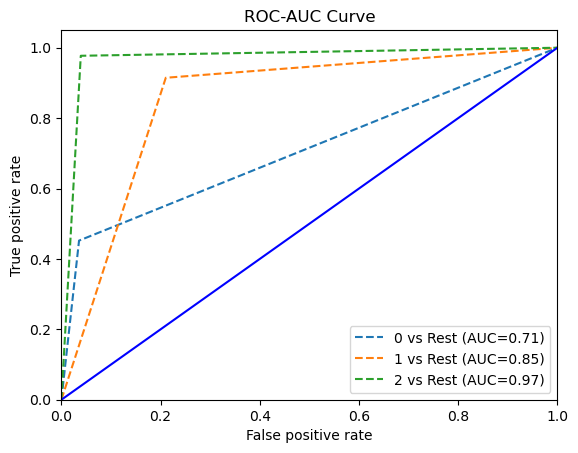

In [38]:
fig, ax = plt.subplots()
f_p_r=dict()
t_p_r = dict()
thres=dict()
rocauc_curve= dict()
total_no_of_class = classes.shape[0]
for i in range(total_no_of_class):    
    f_p_r[i], t_p_r[i], thres[i] = metrics.roc_curve(test_labels[:,i],predlabels_new[:,i])
    rocauc_curve[i] = metrics.auc(f_p_r[i], t_p_r[i])    
    plt.plot(f_p_r[i], t_p_r[i], linestyle='--',label='%s vs Rest (AUC=%0.2f)'%(classes[i],rocauc_curve[i]))

plt.plot([0,1],[0,1],'b-')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('ROC-AUC Curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.show()
fig.savefig('ROCAUC_EfficientNetB3.png', format='png', dpi=300)

In [2]:
from sklearn.metrics import classification_report

In [41]:
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)
print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                precision    recall  f1-score   support

         No_DR       0.52      0.45      0.49        73
          Mild       0.61      0.91      0.74       246
      Moderate       0.97      0.98      0.97       481
        Severe       0.00      0.00      0.00        73
Proliferate_DR       0.00      0.00      0.00        43

     micro avg       0.79      0.79      0.79       916
     macro avg       0.42      0.47      0.44       916
  weighted avg       0.71      0.79      0.75       916
   samples avg       0.79      0.79      0.79       916



C:\Users\Sriya Nukala\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
fpr = dict()
tpr = dict()
thresh =dict()
roc_auc = dict()

n_class = classes.shape[0]
fig=plt.figure(figsize=(10, 8), dpi=300)
for i, in zip(range(n_class)):    
    fpr[i], tpr[i], thresh[i] = metrics.roc_curve(test_labels[:,i],predlabels_new[:,i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    if classes[i]==0:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='NonDemented (AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==1:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='VeryMildDemented (AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==2:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='MildDemented (AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==3:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='ModerateDemented (AUC=%0.2f)'%(roc_auc[i]))
plt.plot([0,1],[0,1],'b-')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()
fig.savefig('myfig_EfficientNet.png',dpi=300)

In [ ]:
fpr = dict()
tpr = dict()
thresh =dict()
roc_auc = dict()

n_class = classes.shape[0]

fig=plt.figure(figsize=(10, 8), dpi=300)
for i in zip(range(n_class)):    
    fpr[i], tpr[i], thresh[i] = metrics.roc_curve(test_labels[:,i],pred_labels[:,i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    if classes[i]==0:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='NonDemented (AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==1:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='VeryMildDemented (AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==2:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='MildDemented (AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==3:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='ModerateDemented (AUC=%0.2f)'%(roc_auc[i]))
plt.plot([0,1],[0,1],'b-')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Testing ROC_AUC_Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()
fig.savefig('brain mri testing roc auc_EfficientNet.png',dpi=300)# roc curve for classes